In [651]:
import mne
import matplotlib.pyplot as plt
from mne.channels import make_standard_montage
from mne_realtime import LSLClient, MockLSLStream, RtEpochs
import numpy as np
import pywt
import pickle

raw_each = [0] * 6

for i in range(0,6):
    raw_each[i] = mne.io.read_raw_edf("C:\git\Senior_Thesis\DataSet\Convert_data\hand"+ str(i) +"_new.edf",preload = True)

# raw_edf = mne.concatenate_raws(raw_each)
# raw_edf = mne.concatenate_raws([raw_each[4]])
raw_edf = mne.io.read_raw_edf("C:\git\Senior_Thesis\DataSet\Convert_data\MI_execution.edf", preload=True)

eeg1 = raw_edf.copy().filter(l_freq=1.0, h_freq=30.0, method = 'iir', iir_params= {"order": 5, "ftype":'butter'})
# eeg1 = raw_edf.copy().filter(l_freq=0.075, h_freq=3.0, method = 'fir')
eeg1 = eeg1.copy().set_eeg_reference(ref_channels="average")

eeg1= eeg1.pick(["Fz","C3", "Cz", "C4","Pz",'PO7','PO8'])
# eeg1= eeg1.pick_channels(["C3", "Cz", "C4"])
events, event_dict = mne.events_from_annotations(eeg1)
combine_epochs = mne.Epochs(eeg1, events, 
        tmin=-2.0,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax=4.0,    # final timestamp (10 means set epoch duration 10 second)
        event_id=event_dict,
        preload = True,
        event_repeated='drop'
    )

combine_epochs = combine_epochs.copy().crop(tmin=0.0, tmax=2.0)

Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand0_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand1_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand2_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand3_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand4_n

In [652]:
combine_epochs.event_id

{'OVTK_GDF_Cross_On_Screen': 1,
 'OVTK_GDF_End_Of_Session': 2,
 'OVTK_GDF_End_Of_Trial': 3,
 'OVTK_GDF_Feedback_Continuous': 4,
 'OVTK_GDF_Incorrect': 5,
 'OVTK_GDF_Left': 6,
 'OVTK_GDF_Right': 7,
 'OVTK_GDF_Start_Of_Trial': 8,
 'OVTK_GDF_Tongue': 9,
 'OVTK_GDF_Up': 10,
 'OVTK_StimulationId_BaselineStart': 11,
 'OVTK_StimulationId_BaselineStop': 12,
 'OVTK_StimulationId_Beep': 13,
 'OVTK_StimulationId_ExperimentStart': 14,
 'OVTK_StimulationId_Train': 15}

In [653]:
combine_epochs

Number of events,605
Events,OVTK_GDF_Cross_On_Screen: 2OVTK_GDF_End_Of_Session: 1OVTK_GDF_End_Of_Trial: 120OVTK_GDF_Feedback_Continuous: 120OVTK_GDF_Incorrect: 1OVTK_GDF_Left: 30OVTK_GDF_Right: 30OVTK_GDF_Start_Of_Trial: 119OVTK_GDF_Tongue: 30OVTK_GDF_Up: 30OVTK_StimulationId_BaselineStart: 1OVTK_StimulationId_BaselineStop: 1OVTK_StimulationId_Beep: 120OVTK_StimulationId_ExperimentStart: 0OVTK_StimulationId_Train: 0
Time range,0.000 – 2.000 s
Baseline,-2.000 – 0.000 s


In [654]:
# Prepare Labels and Train data
labels = combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Up','OVTK_GDF_Tongue'].events[:,2]
for i in range(0,len(labels)):
    if labels[i] > 7:
        labels[i] = labels[i] - 1
    # if labels[i] < 7:
    #     labels[i] = labels[i] + 1
    
train_data = combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Up','OVTK_GDF_Tongue'].get_data()
# train_data = combine_epochs['OVTK_GDF_Start_Of_Trial'].get_data()

Load CSP Weight

In [655]:
component_num = 7

with open('trained_csp_model.pkl', 'rb') as file:
    trained_csp = pickle.load(file)

new_data = trained_csp.transform(train_data)

In [656]:
new_data.shape

(120, 7, 501)

CWT Transformation

In [657]:
train_cwt = np.ndarray(shape=(new_data.shape[0], new_data.shape[2], component_num))
for jj in range(0, new_data.shape[0]):
    train_cwt[jj] = new_data[jj].T
print(np.shape(new_data))

scales = range(1,31)

waveletname = 'morl'
train_size = new_data.shape[0]
train_data_cwt = np.ndarray(shape=(train_size, len(scales), new_data.shape[2], component_num))

for ii in range(0,train_size):
    if ii % 40 == 0:
        print(ii)
    for jj in range(0,component_num):
        signal = train_cwt[ii, :, jj]
        coeff, _ = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:new_data.shape[2]]  #crop 227 sample for each channel
        train_data_cwt[ii, :, :, jj] = coeff_
print(np.shape(train_data_cwt))

train_cwt_stack = np.ndarray(shape=(train_size, len(scales)*component_num, new_data.shape[2]))

for jj in range(0,train_data_cwt.shape[0]):
    train_cwt_stack[jj] = np.vstack((train_data_cwt[jj,:,:,0], train_data_cwt[jj,:,:,1], train_data_cwt[jj,:,:,2], train_data_cwt[jj,:,:,3], train_data_cwt[jj,:,:,4], train_data_cwt[jj,:,:,5], train_data_cwt[jj,:,:,6]))

print(np.shape(train_cwt_stack))

(120, 7, 501)
0


40
80
(120, 30, 501, 7)
(120, 210, 501)


Classification with trained model

In [658]:
import keras
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
pretrained_model = load_model("CNN_try_model_weights.h5")
num_classes = 4

y_pred_raw = pretrained_model.predict(train_cwt_stack)
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
y_pred = np.argmax(y_pred_raw, axis=1) 

4/4 [==============================] - 2s 438ms/step


4/4 [==============================] - 2s 442ms/step - loss: 0.7413 - accuracy: 0.7000


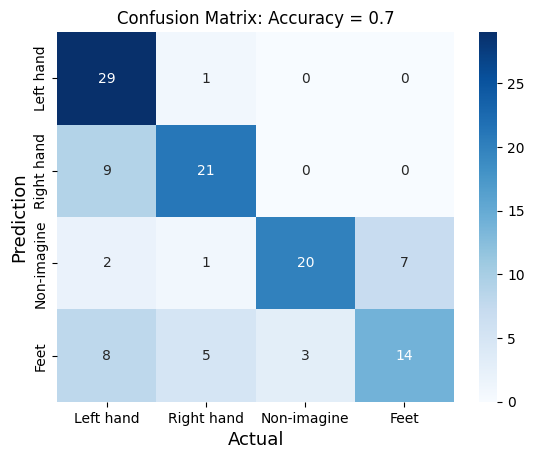

In [659]:
y_test = keras.utils.to_categorical(labels -6 , num_classes)
y_true = np.argmax(y_test, axis=1)
confusion_mat = confusion_matrix(y_true, y_pred)
loss, accuracy = pretrained_model.evaluate(train_cwt_stack, y_test)

class_names = ['Left hand', 'Right hand',  'Non-imagine', 'Feet']

sns.heatmap(confusion_mat, 
            annot=True,
            fmt='d', 
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title("Confusion Matrix: Accuracy = "+ str(round(accuracy,3)))
plt.show()

In [660]:
y_pred_raw

array([[0.492059, 0.308863, 0.162806, 0.036272],
       [0.107753, 0.799385, 0.065473, 0.027390],
       [0.131853, 0.832358, 0.017376, 0.018413],
       [0.924100, 0.006448, 0.001139, 0.068312],
       [0.036432, 0.040201, 0.671663, 0.251705],
       [0.953241, 0.015604, 0.025149, 0.006006],
       [0.009377, 0.968398, 0.006854, 0.015371],
       [0.996475, 0.001516, 0.001935, 0.000074],
       [0.996712, 0.002344, 0.000641, 0.000303],
       [0.265941, 0.137015, 0.423673, 0.173372],
       [0.540638, 0.420552, 0.030451, 0.008360],
       [0.958778, 0.011751, 0.001585, 0.027887],
       [0.008610, 0.077020, 0.105341, 0.809030],
       [0.754758, 0.106835, 0.083540, 0.054867],
       [0.017874, 0.970418, 0.010965, 0.000743],
       [0.012602, 0.525621, 0.455666, 0.006111],
       [0.435681, 0.006231, 0.410737, 0.147351],
       [0.182658, 0.147517, 0.040630, 0.629195],
       [0.358743, 0.600538, 0.015137, 0.025582],
       [0.989128, 0.001837, 0.002051, 0.006984],
       [0.074964, 0.

Note of y_pred classes :
    0 = Left,
    1 = Right,
    2 = Non-imagine,
    3 = Feet 

In [661]:
y_pred

array([0, 1, 1, 0, 2, 0, 1, 0, 0, 2, 0, 0, 3, 0, 1, 1, 0, 3, 1, 0, 3, 0,
       1, 0, 0, 0, 1, 0, 2, 0, 3, 3, 2, 1, 0, 0, 2, 1, 3, 3, 2, 1, 3, 0,
       3, 0, 1, 0, 2, 2, 1, 0, 2, 0, 1, 0, 2, 1, 1, 0, 2, 1, 1, 0, 1, 3,
       1, 3, 2, 3, 0, 0, 1, 0, 1, 0, 1, 2, 0, 3, 3, 3, 1, 0, 2, 0, 3, 0,
       2, 0, 1, 0, 2, 0, 1, 0, 2, 3, 0, 1, 3, 2, 0, 0, 2, 3, 0, 0, 2, 0,
       1, 0, 3, 3, 0, 0, 2, 2, 2, 0], dtype=int64)

In [662]:
combine_epochs

Number of events,605
Events,OVTK_GDF_Cross_On_Screen: 2OVTK_GDF_End_Of_Session: 1OVTK_GDF_End_Of_Trial: 120OVTK_GDF_Feedback_Continuous: 120OVTK_GDF_Incorrect: 1OVTK_GDF_Left: 30OVTK_GDF_Right: 30OVTK_GDF_Start_Of_Trial: 119OVTK_GDF_Tongue: 30OVTK_GDF_Up: 30OVTK_StimulationId_BaselineStart: 1OVTK_StimulationId_BaselineStop: 1OVTK_StimulationId_Beep: 120OVTK_StimulationId_ExperimentStart: 0OVTK_StimulationId_Train: 0
Time range,0.000 – 2.000 s
Baseline,-2.000 – 0.000 s


In [663]:
result_array = y_pred[y_pred == 2]
print('non-imagine TRUE: ', len(result_array) / 120 * 100)

non-imagine TRUE:  19.166666666666668
